# Feature Engineering

In [1]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

## Carga de datos

Se cargan las columnas con formatos adecuados según el tipo de datos.  
Se usa como índice building_id para train_values y train_labels  

In [2]:
# Train values
# Levantar los datos de cada edificio/casa
df = pd.read_csv('datos/train_values.csv',nrows=0)
columnas = df.columns.to_list()
datatypes = {
    **{columnas[0]:np.int32}\
    , **{column:np.int16 for column in columnas[1:8] + columnas[27:28]}\
    , **{column:'category' for column in columnas[8:15] + columnas[26:27]}\
    , **{column:np.bool for column in columnas[15:26] + columnas[28:39]}
}
train_values = pd.read_csv('datos/train_values.csv',dtype=datatypes)
train_values = train_values.set_index("building_id")
columnas = train_values.columns.to_list()

In [3]:
#Train labels
train_labels = pd.read_csv('datos/train_labels.csv',index_col='building_id')

## Información de los datasets

In [10]:
train_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          260601 non-null  int16   
 1   geo_level_2_id                          260601 non-null  int16   
 2   geo_level_3_id                          260601 non-null  int16   
 3   count_floors_pre_eq                     260601 non-null  int16   
 4   age                                     260601 non-null  int16   
 5   area_percentage                         260601 non-null  int16   
 6   height_percentage                       260601 non-null  int16   
 7   land_surface_condition                  260601 non-null  category
 8   foundation_type                         260601 non-null  category
 9   roof_type                               260601 non-null  category
 10  ground_floor_type          

In [11]:
train_values.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,False,False,False,False,False,False,False,False,False,False
28830,8,900,2812,2,10,8,7,o,r,n,...,False,False,False,False,False,False,False,False,False,False
94947,21,363,8973,2,10,5,5,t,r,n,...,False,False,False,False,False,False,False,False,False,False
590882,22,418,10694,2,10,6,5,t,r,n,...,False,False,False,False,False,False,False,False,False,False
201944,11,131,1488,3,30,8,9,t,r,n,...,False,False,False,False,False,False,False,False,False,False


In [12]:
train_labels.head()

,damage_grade
building_id,
802906,3
28830,2
94947,3
590882,2
201944,3


## Feature Importance

Utilicemos Random Forest para ver la importancia de los features  
Importamos lo necesario para correr Random Forest

In [13]:
# for preprocessing the data
from sklearn.preprocessing import StandardScaler

# the model
from sklearn.ensemble import RandomForestClassifier

# for combining the preprocess with model training
from sklearn.pipeline import make_pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV

# Para ver los parametros que se utilizan
from pprint import pprint
import pickle

In [14]:
## Se obtiene de correr con RF todos los features originales
filename = 'all_features_rf_n150_minleaf3.sav'

In [15]:
loaded_model = pickle.load(open(filename, 'rb'))

In [16]:
feature_importance = loaded_model.best_estimator_.named_steps["randomforestclassifier"].feature_importances_
sorted_idx = feature_importance.argsort()
len(feature_importance)

68

El modelo se entreno con todos los features y get_dummies

In [17]:
train_values_subset = pd.get_dummies(train_values)

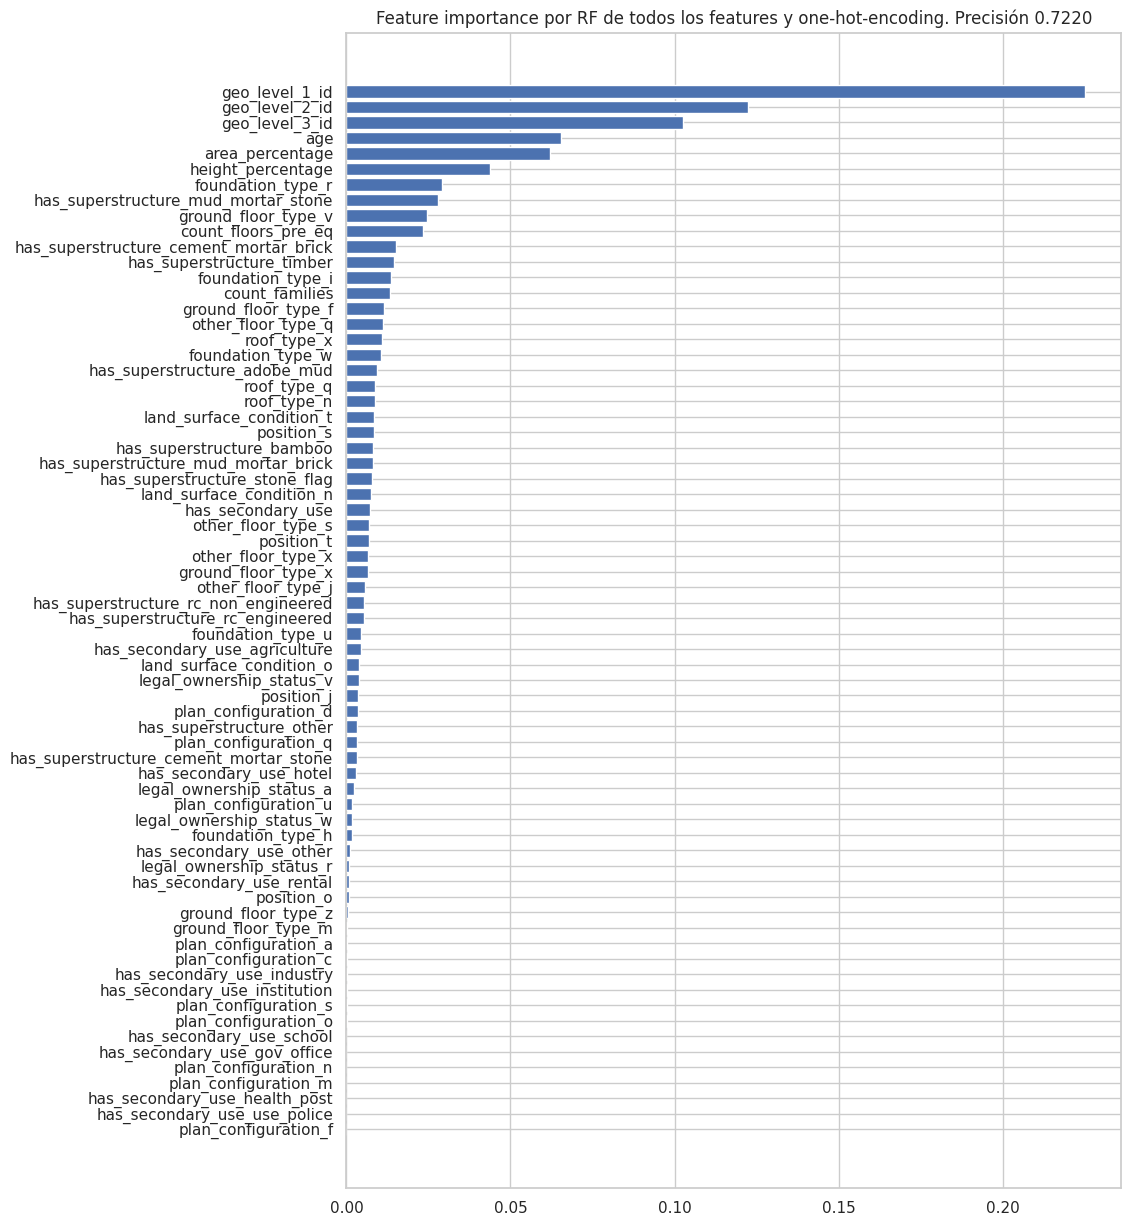

In [18]:
#Grafico de feature importance
fig, ax = plt.subplots(figsize=(10,15))
ax.barh(train_values_subset.columns[sorted_idx],feature_importance[sorted_idx])
ax.set_title('Feature importance por RF de todos los features y one-hot-encoding. Precisión 0.7220')
plt.show()

Usando XGBOOST

In [19]:
#Se obtiene de correr con XGBoost todos los features y max depth 10
filename = 'all_features_xgb_md10.sav'

In [20]:
loaded_model = pickle.load(open(filename, 'rb'))

In [21]:
feature_important = loaded_model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)

El modelo se entreno con todos los features y get_dummies

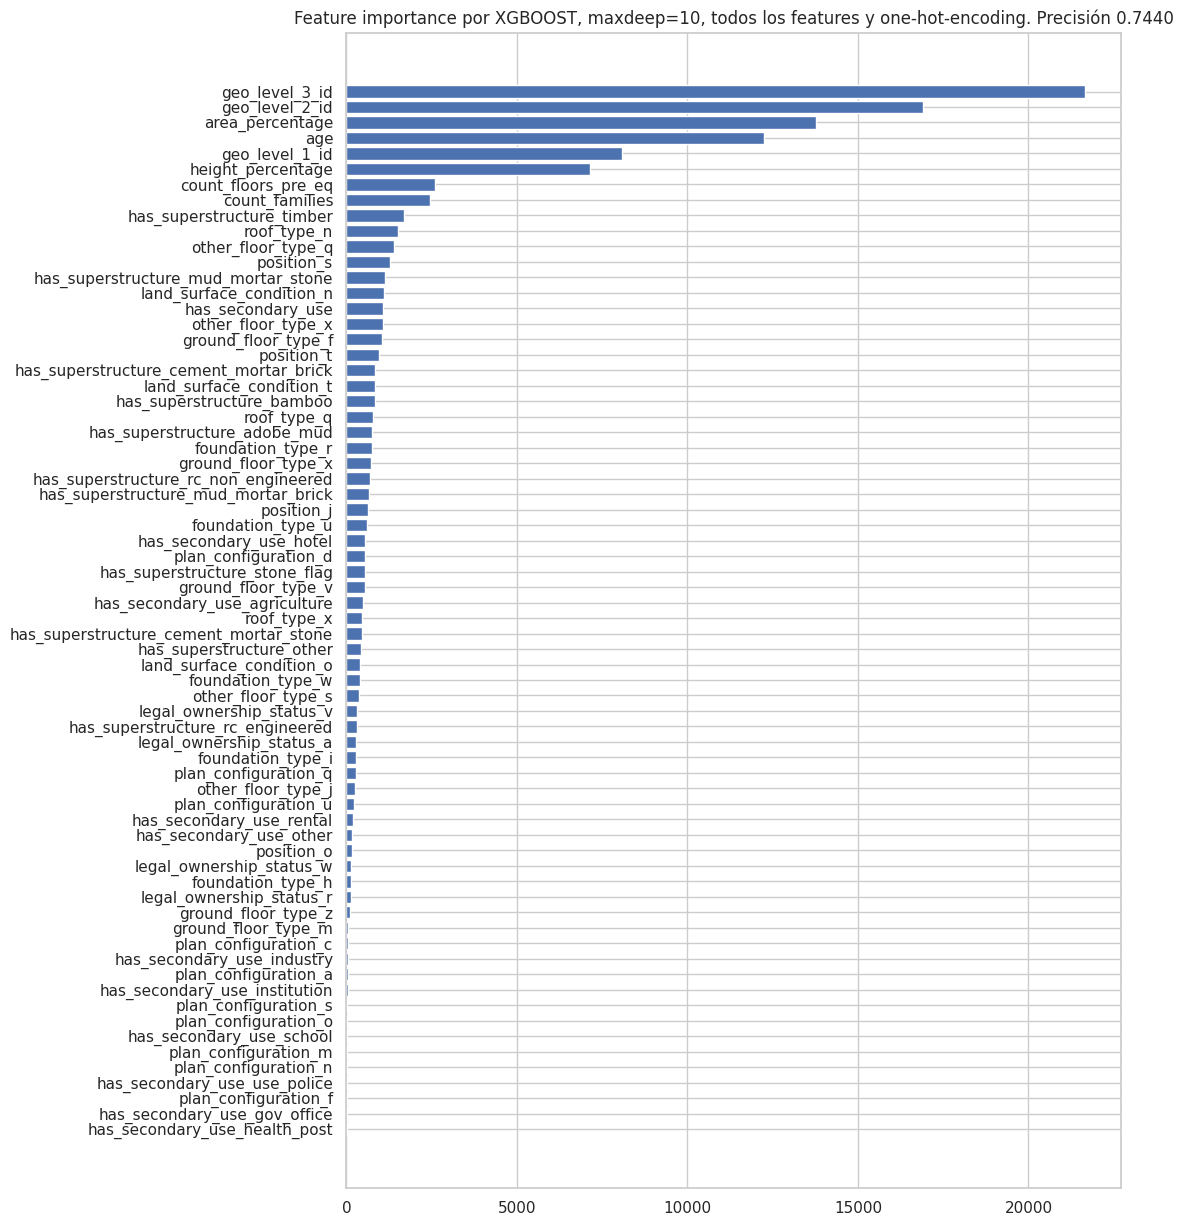

In [22]:
#Grafico de feature importance
fig, ax = plt.subplots(figsize=(10,15))
ax.barh(data.index,data['score'].values)
ax.set_title('Feature importance por XGBOOST, maxdeep=10, todos los features y one-hot-encoding. Precisión 0.7440')
plt.show()

## Conclusiones de Feature importance

*  Las variantes has_secondary_use tienen muy poca importancia para XGBoost. Nos podemos quedar solo con la de has_secondary_use a secas.
*  Plan_configuration es el que lo sigue en menor importancia para el algoritmo. Considerar una transformación apropiada. "Si está alquilada->la cuidan menos->más deteriorada está->más riesgo de derrumbe ?)"
*  El resto es analizar columna por columna.

In [117]:
# Elimino las variantes de has_secondary_use
train_values_base = train_values.iloc[:,:28]

In [110]:
# #elimino has_secondary_use
# train_values_base = train_values.iloc[:,:26]
# #borro legal_ownership
# train_values_base = train_values_base.drop(labels='legal_ownership_status',axis=1)

In [118]:
train_values_base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 28 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          260601 non-null  int16   
 1   geo_level_2_id                          260601 non-null  int16   
 2   geo_level_3_id                          260601 non-null  int16   
 3   count_floors_pre_eq                     260601 non-null  int16   
 4   age                                     260601 non-null  int16   
 5   area_percentage                         260601 non-null  int16   
 6   height_percentage                       260601 non-null  int16   
 7   land_surface_condition                  260601 non-null  category
 8   foundation_type                         260601 non-null  category
 9   roof_type                               260601 non-null  category
 10  ground_floor_type          

## Analisis columna por columna

## Geo Level Id

Analizar para los geo_level_id que más daño sufrieron cuales son las características más importantes y se puede hacer un feature booleano.  
Podemos hacer mean encoding y poner el porcentaje de esa ciudad.  
Por ejemplo para todos los que pertenezcan al geo_level_id_1 "17", tendrán una nueva columna con geo_level_id_1_dmg "80.15" porque en esa zona hubo ese porcentaje de daño.  
Problemas: 
- leak del daño 
- ¿Es necesario más granularidad? (también para otros geo_level_id?)   
- Los id son útiles porque si fue una zona donde hubo gran cantidad de daño entonces un nuevo valor verá en que id pertenece y de ahí determinar que es lo más probable. 

# Columnas mal distribuidas (age,area_percentage,height_percentage)

### area_percentage

In [119]:
from scipy.stats.mstats import winsorize

<AxesSubplot:>

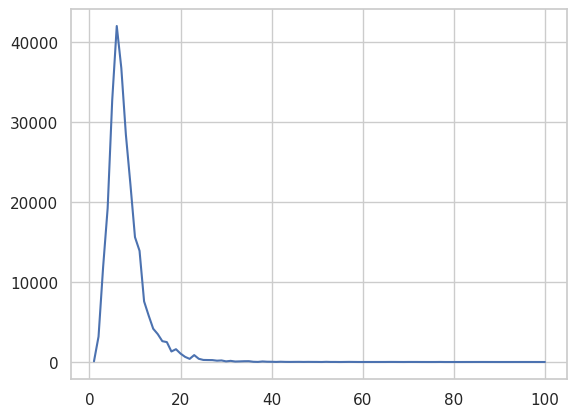

In [120]:
train_values_base['area_percentage'].value_counts().sort_index().plot()

<AxesSubplot:>

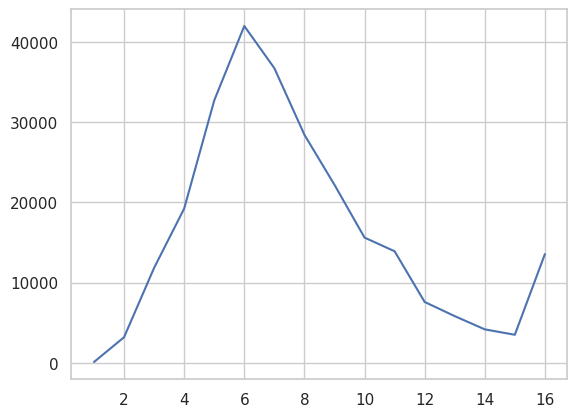

In [121]:
# A la vista, quiero que el máximo sea 12 porque a partir de ese valor empieza a decrecer más lento. 
# También puede ser 20 pero lo sigue dejando poco distruido. Elijo 16 (el promedio) que se alcanza on percentile 0.05 
area_percentage_winsorized = winsorize(train_values_base['area_percentage'],(0,0.05))
columna_area_percentage_w = pd.Series(np.ma.filled(area_percentage_winsorized))
columna_area_percentage_w.value_counts().sort_index().plot()

<AxesSubplot:>

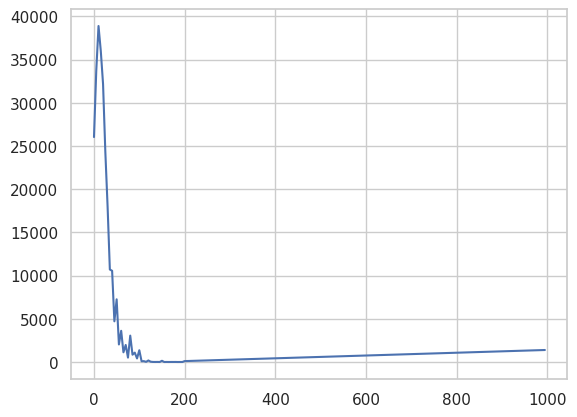

In [122]:
train_values_base['age'].value_counts().sort_index().plot()

<AxesSubplot:>

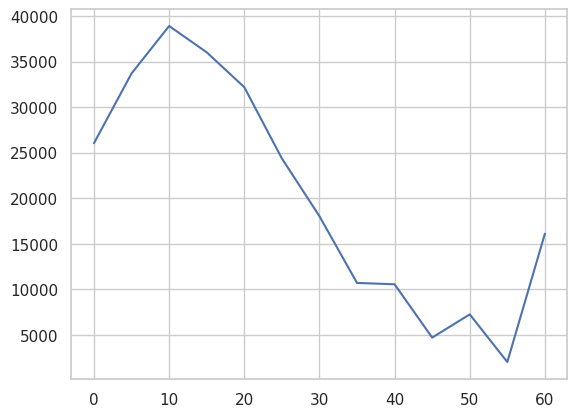

In [123]:
#El valor 60 es un buen valor para que sea el máximo. Más alla de 60 se considera antigua.
age_winsorized = winsorize(train_values_base['age'],(0,0.05))
columna_age_w = pd.Series(np.ma.filled(age_winsorized))
columna_age_w.value_counts().sort_index().plot()

<AxesSubplot:>

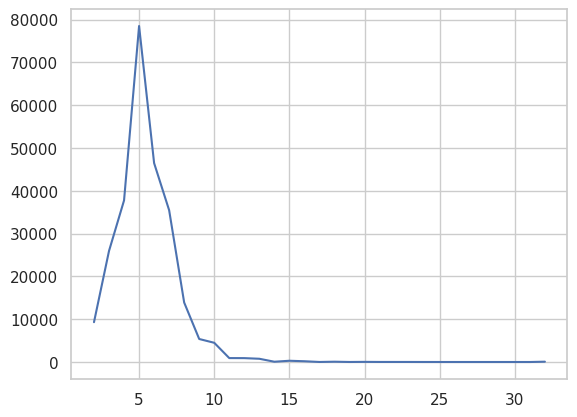

In [124]:
train_values_base['height_percentage'].value_counts().sort_index().plot()

<AxesSubplot:>

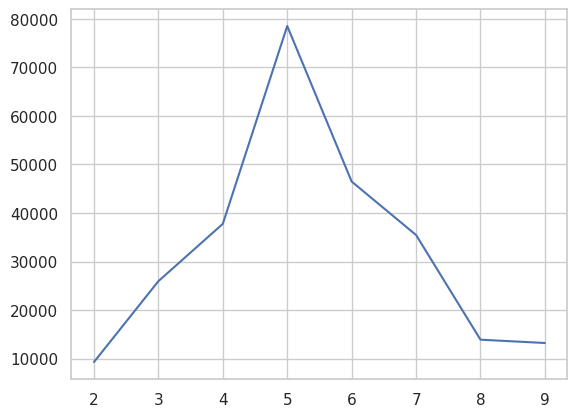

In [125]:
#Percentile 5 más alto.
height_percentage_winsorized = winsorize(train_values_base['height_percentage'],(0,0.05))
columna_height_percentage_w = pd.Series(np.ma.filled(height_percentage_winsorized))
columna_height_percentage_w.value_counts().sort_index().plot()

Probamos el algoritmo con este data set base

In [126]:
train_values_base['area_percentage'] = columna_area_percentage_w
train_values_base['age'] = columna_age_w
train_values_base['height_percentage'] = columna_height_percentage_w

In [127]:
train_values_subset = pd.get_dummies(train_values_base)

XGBoost

In [128]:
import xgboost as xgb
import time

In [129]:
## Objective: mult:softprob. Es una softmax (clasificación de mas de 2 clases, como en este caso que hay 3 daños)
## Learning_rate: un valor alto puede saltearse en óptimo y uno muy bajo puede quedarse atrapado en un mínimo local
## XGBoost usa todos los nucleos (njobs=-1) por defecto
xgb_model = xgb.XGBClassifier(objective="multi:softmax",eval_metric='mlogloss',random_state=99)

In [130]:
start_time = time.time()
xgb_model.fit(train_values_subset,train_labels.values.ravel() )
print("--- Duración: %s segundos ---" % (time.time() - start_time))

--- Duración: 55.64841628074646 segundos ---


In [131]:
from sklearn.metrics import f1_score
y_pred = xgb_model.predict(train_values_subset)
f1_score(train_labels, y_pred, average='micro')

0.7386809720607366

Registro de scores (random_state = 99, con objective=multi:softmax y eval_metric= mlogloss sin nada más):
* Sin features de has_secondary y sin plan_configuration ->0.7430
* Sin features de has_secondary específicos -> 0.743922
* Sin features de has_secondary, winsorizing para age, area_percentage y height_percentage, todos 0.05 para los valores máximos. Res -> 0.7386
* 